In [137]:
import sys
import os
from IPython.core.display import display, HTML

os.environ['NUMBAPRO_CUDALIB']=r"C:\Users\hyli\Anaconda3\envs\python36\Library\bin"
#os.environ['NUMBAPRO_CUDALIB']=r"C:\Users\hyli93\Miniconda3\envs\py3gpu\Library\bin"

sys.path.append('C:/Users/hyli/Documents/GitHub/Phasing/')
display(HTML("<style>.container { width:95% !important; }</style>"))


import numpy as np
import numba
import matplotlib.pyplot as plt
from scipy import ndimage
import PhaseTool

# Create a smooth object

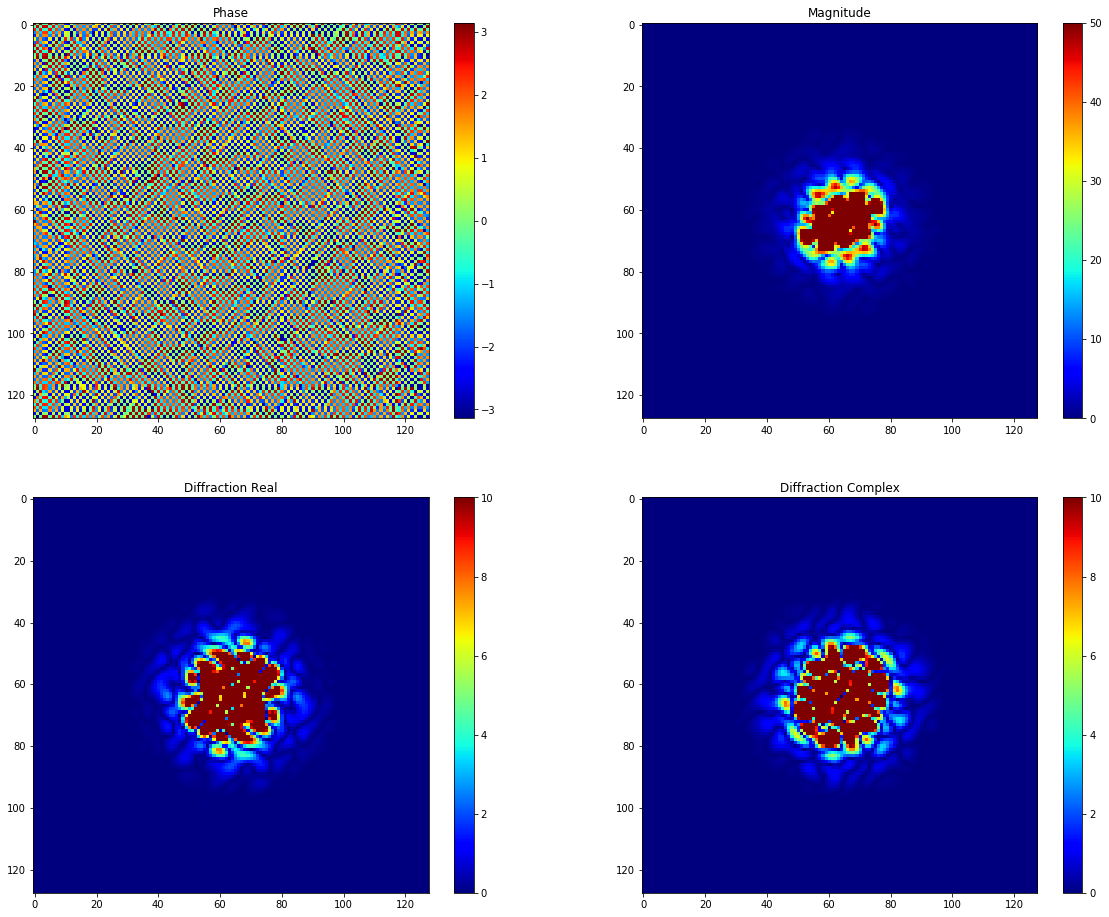

In [138]:
sample = PhaseTool.util.get_smooth_sample(support_length=32, space_length=128, obj_num=20)

diffraction = np.fft.ifftshift(np.fft.fftn(sample))
magnitude = np.abs(diffraction)

# Set up the canvas
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(16)
fig.set_figwidth(20)

im = axes[0,0].imshow(np.angle(diffraction), cmap='jet')
fig.colorbar(im, ax=axes[0,0])
axes[0,0].set_title("Phase")

im = axes[0,1].imshow(magnitude, vmax=50, cmap='jet')
fig.colorbar(im, ax=axes[0,1])
axes[0,1].set_title("Magnitude")

im = axes[1,0].imshow(np.abs(diffraction.real), vmax=10,cmap='jet')
fig.colorbar(im, ax=axes[1,0])
axes[1,0].set_title("Diffraction Real")

im = axes[1,1].imshow(np.abs(diffraction.imag), vmax=10,cmap='jet')
fig.colorbar(im, ax=axes[1,1])
axes[1,1].set_title("Diffraction Complex")

# Show the canvas
plt.show()  

In [165]:
epsilon = np.finfo(np.float64).eps


@numba.vectorize([numba.complex64(numba.complex64), numba.complex128(numba.complex128)])
def get_phase(x):
    """
    Calculate the norm of the vector
    :param x:
    :return:
    """
    value = np.abs(x)
    if value >= epsilon:
        return x / value
    return x

def iterative_projection_normal(data_dict, holder_dict, a, b, c, d, e, f):
    # Because this is a very basic function, I will not check paramters or counting the time
    
    tmp = np.copy(data_dict["density"])
    
    # Get data variables
    mag = data_dict['magnitude array']
    mag_m = data_dict['magnitude mask']
    density = data_dict['density']
    support = data_dict['support']

    # Get holder variables
    support_m = holder_dict['modified support']
    support_mn = holder_dict['modified support not']
    support_t = holder_dict['support holder temporary']

    ndens_t = holder_dict['new density tmp']

    ndiff_m = holder_dict['new diffraction magnitude']
    ndiff_c = holder_dict['diffraction with magnitude constrain']
    phase = holder_dict['phase holder']

    # Step 1: Calculate the fourier transformation of the density
    ndiff_c[:] = np.fft.fftn(density)
    
    phase[:] = get_phase(ndiff_c)
    
    np.multiply(mag[mag_m], phase[mag_m], out=ndiff_c[mag_m])

    # Step 3: Get the updated density
    ndens_t[:] = np.fft.ifftn(ndiff_c).real[:]

    # Step 4: Apply real space constrain
    # Get the positions where to modify
    support_m[:] = support[:]

    support_t[support] = e * ndens_t[support] + f * density[support]
    np.greater(support_t[support], 0, out=support_m[support])

    # Update the modified support not
    np.logical_not(support_m, out=support_mn[:])

    # Apply the real space update rule
    density[support_mn] = c * ndens_t[support_mn] + d * density[support_mn]
    density[support_m] = a * ndens_t[support_m] + b * density[support_m]

    print(np.sum(np.abs(density - tmp)))


In [166]:
# Step 1: Create a object
alter_proj = PhaseTool.AlterProj.BaseAlterProj()
# Step 2: Initialize the object with the data
alter_proj.initialize_easy(magnitude=np.fft.ifftshift(magnitude),
                           magnitude_mask=np.ones_like(magnitude,dtype=np.bool),
                           full_initialization=True)
# Step 3: Set initial guess
alter_proj.set_zeroth_iteration_value(fill_detector_gap=False, phase="Zero")
alter_proj.update_input_dict()
# Step 3: Set the algorithm
alter_proj.set_algorithm(alg_name="HIO")

The center of the diffraction is :
[ 64.  64.]
Initialize the support array with the auto-correlation array using default methods with default parameters.


In [167]:
# Run one step
iterative_projection_normal(alter_proj.data_dict, alter_proj.holder_dict, 
                            a=alter_proj.param_dict['par_a'],
                            b=alter_proj.param_dict['par_b'],
                            c=alter_proj.param_dict['par_c'],
                            d=alter_proj.param_dict['par_d'],
                            e=alter_proj.param_dict['par_e'],
                            f=alter_proj.param_dict['par_f'])

91.7185531634


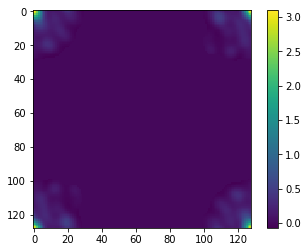

In [168]:
plt.imshow(alter_proj.holder_dict["support holder temporary"])
plt.colorbar()
plt.show()

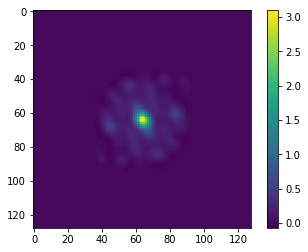

In [151]:
plt.imshow(np.fft.ifftshift(alter_proj.data_dict["density"]))
plt.colorbar()
plt.show()

In [152]:
alter_proj.param_dict

{'par_a': 1.0,
 'par_b': 0.0,
 'par_c': -0.87,
 'par_d': 1.0,
 'par_e': 1.0,
 'par_f': 0.0,
 'epsilon': 1e-15}

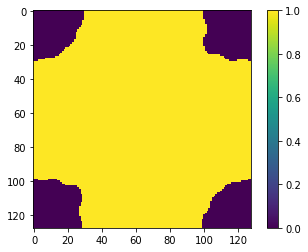

In [160]:
plt.imshow(alter_proj.holder_dict["modified support not"])
plt.colorbar()
plt.show()

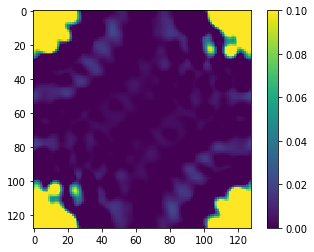

In [159]:
plt.imshow(alter_proj.holder_dict["new density tmp"], vmax=0.1, vmin=0)
plt.colorbar()
plt.show()

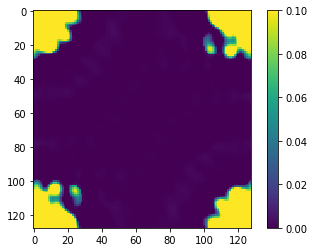

In [161]:
plt.imshow(alter_proj.data_dict["density"], vmax=0.1, vmin=0)
plt.colorbar()
plt.show()

In [109]:
np.sum()

16384